In [31]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# 24 - 双重差分传奇

在讨论完处理效应异质性之后，我们现在回到平均处理效应。接下来的几章，我们将介绍面板数据方法的一些最新进展。面板是一种按时间重复观察同一个单位的数据结构。由于我们观察同一单位多个时间段的情况，可以查看处理发生前后的变化。这使面板数据成为在无法随机化时识别因果效应的有希望的替代方案。

为了激励面板数据的使用，我们将主要讨论营销领域的因果推断应用。营销特别有趣，因为在这个领域进行随机实验非常困难。在营销中，我们往往无法控制谁接受处理，即谁看到我们的广告。当一个新用户访问我们的网站或下载我们的应用时，我们无法很好地知道他是否看过我们的营销活动，还是由于其他因素而来。

（注意：对于熟悉营销归因的人来说，我知道有许多归因工具旨在解决这个问题。但我也知道它们有许多局限性。）

离线营销的问题更大。你如何知道一场电视广告的价值是否超过其成本？因此，在营销中常见的做法是地理实验（Geo-Experiments）：我们在某些地理区域投放营销活动而不在其他区域投放，然后进行比较。在这种设计中，面板数据方法尤其有趣：我们可以收集整个地理区域（单位）在多个时间段的数据。为了理解这种数据并识别因果效应，或许最流行的方法是双重差分（DiD）家族。

2020 年和 2021 年对我们大多数人来说都不容易。但对 DiD 来说尤其难。大量的最新研究凸显了这些方法的一些严重缺陷，这些缺陷在过去并不为人所知。因此，尽管我们已经在第一部分中有一章介绍 DiD，但那里的内容比较入门。它没有涵盖围绕面板数据方法的新发现和激烈讨论。现在我们应该更彻底地了解它们，从 DiD 开始。在这一章中，我将尝试总结最近发现的 DiD 问题，并展示如何解决它们。本章分为三个部分：

1. **诞生**：回顾为什么面板数据对因果推断如此有吸引力，以及 DiD 和双向固定效应（TWFE）如何利用时间结构。
2. **死亡**：消化 DiD 和 TWFE 模型隐含的一个关键假设，该假设一直被忽视。理解该假设何时及如何会失败。
3. **启蒙**：在了解了 DiD 和 TWFE 的问题后，我们可以思考解决方案。本节展示了对第二节问题的一个简单变通方法。

让我们直接进入正题！

## 1) 诞生：面板数据的承诺

![img](./images/24/promise.png)

正如我所说，面板数据是我们在多个时间段观察多个单位 `i` 的数据。想想美国的政策评估场景，你想考察大麻合法化对犯罪率的影响。你拥有多个州 `i` 在多个时间段 `t` 的犯罪率数据。你还观察到每个州何时采取了支持大麻合法化的立法。我希望你能看出这对因果推断而言何等强大。将大麻合法化视为处理 `D`（因为 `T` 用来表示时间）。我们可以追踪最终会被处理的某个州的犯罪率趋势，看看处理时间是否带来了趋势的变化。从某种程度上说，一个州在前后对比中充当了自己的控制单位。此外，由于我们有多个州，我们还可以比较处理州和控制州。当我们把这两种比较放在一起——处理与控制以及处理前与处理后——我们最终得到了一个极其强大的工具去推断反事实，从而获得因果效应。

面板数据方法经常用于政府政策评估，但我们可以轻松论证它们对（科技）行业也非常有用。公司通常会在多个时间段跟踪用户数据，这导致了丰富的面板数据结构。不仅如此，有时实验不可行，因此我们必须依赖其他识别策略。为了进一步探索这一想法，我们考虑一个假想例子：一家年轻的科技公司在多个城市跟踪其应用的安装人数。在 2021 年的某个时候，这家公司在其应用中推出了一个新功能。它现在想知道这个功能为公司带来了多少新增用户。推出是渐进的。有些城市在 `2021-06-01` 得到新功能，另一些在 `2021-07-15`。其余城市的全面推出要到 2022 年才进行。由于我们的数据只到 `2021-07-31`，最后这组城市可视为对照组。用因果推断的术语说，推出这一功能可以看作处理，安装量可以看作结局变量。我们想知道处理对结果的效应，也就是新功能对安装量的影响。

请注意，这家科技公司无法在此做实验。他们不能控制哪个人知道自己有新功能。我们说他们对处理分配的控制有限。这是因为分析单位是**尚未成为其客户的人**。他们想知道能通过安装应用将多少人转化为客户。当然，他们无法对这些人随机化。因此，相反，他们将分析单位改为城市。在一个城市而非另一个城市推出功能是他们可以控制的，而对个人的推出则不行。

在某一特定时间得到功能（被处理）的一组城市称为 cohort（队列）。在我们的例子中，我们有三个 cohort：一个在 `2021-06-01` 被处理，另一个在 `2021-07-15` 被处理，还有一个控制 cohort，在我们的数据结束后才会被处理。为了了解这份数据是什么样子，让我们绘制按 cohort 分组的日均安装量。


In [34]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


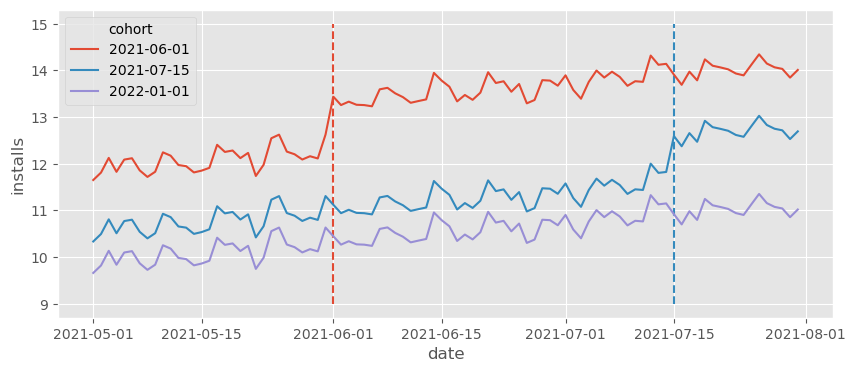

In [36]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

虚线标记了各 cohort 获得处理（特性推出）的时刻。花些时间欣赏上图数据的丰富性。首先，我们可以看到每个 cohort 都有自己的基线水平。这只是因为不同城市人口规模不同，导致安装量因城市规模而异。例如，看起来第一批 cohort（6 月 1 日被处理的城市）的基线更高，而对照 cohort 的安装基线更低。这意味着仅仅比较处理 cohort 和对照 cohort 会得到偏差的结果，因为控制组的 $Y_0$ 低于处理组，即 $Y_{0}|G=Control < Y_{0}|G=Treated$，其中我们用 $G$ 表示 cohort。幸运的是，这不会成为问题。面板数据允许我们跨城市**和**时间进行比较，从而调整不同的基线。

说到时间，可以看到有一个总体上升趋势，并伴有一些波动（看起来像每周季节性）。关注对照 cohort，可以看到日安装量从 5 月的约 10 个增加到 6 月的约 11 个，增长了约 1 个。用技术术语来说，后期时间段的 $Y_0$ 高于早期时间段。这意味着仅仅比较同一城市跨时间的变化也会产生偏差。再次庆幸的是，面板数据结构允许我们不仅跨时间比较，还能跨城市比较，从而调整趋势。

理想情况下，为了推断该新功能上线对安装量的影响，我们想知道那些获得功能的 cohort 如果没有得到它会发生什么。我们想估计处理组在处理之后时期的反事实结果 $Y(0)$。如果我们用 cohort 获得处理的时间 `g` 来标记每个 cohort（记住 cohort 只是同一时间被处理的一组城市），我们可以将该反事实写为 $E[Y_0\mid t \geq g]$，然后把 cohort `g` 的处理效应（ATT）定义为：

$$
E[Y_1\mid t \geq g] - E[Y_0\mid t\geq g]
$$

接下来的问题是如何从我们拥有的数据中估计这一点。一种方法是利用面板数据结构的力量来估计这些反事实。例如，我们可以使用线性回归和双重差分公式得到双向固定效应模型。假设每个城市 `i` 有一个基础安装水平 \(\gamma_i\)。这与我们之前所见联系起来：也许一个城市有更多的安装是因为它人口更大，或者因为其文化更符合我们公司的产品。无论原因是什么，即使我们不知道，我们说这些单位特异性可以通过一个**单位固定参数** \(\gamma_i\) 捕捉。同样，我们可以说每个时间 `t` 有一个基线安装水平，我们可以用一个**时间固定参数** \(\theta_t\) 来捕捉。如果是这样，一个好的建模方式是说安装量取决于城市（单位）效应 \(\gamma\) 和时间效应 \(\theta\)，再加上一些随机噪声。

$$
Installs_{it} = \gamma_i + \theta_t + e_{it}
$$

为了把处理纳入这个模型，我们定义变量 \(D_{it}\)，当单位被处理时取 1，否则取 0。在我们的例子中，这个变量对于永不被处理的 cohort 始终为零；对于其他 cohort，在其处理日期之前为零，之后为一。


In [39]:
formula = f"""installs ~ treat + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat"]

1.000000000000027

由于我在上面模拟了数据，我确切地知道真实的个体处理效应，它存储在 `tau` 列中。既然 TWFE 应该能恢复处理组的处理效应，我们可以验证真实的 ATT 是否与上述估计匹配。我们所要做的只是筛选出被处理的单位和时期（`treat==1`），然后计算 `tau` 列的平均值。

In [42]:
df.query("treat==1")["tau"].mean()

1.0

在有人指出给每个单位生成一个虚拟变量会在大数据中不切实际之前，我先承认，确实如此。但有一个简单的解决办法。我们可以用 FWL 定理将那一个回归分成两个。事实上，上述模型在数值上等价于估计下面这个模型

$$
\tilde{Installs}_{it} = \tau \tilde D_{it} + e_{it}
$$

其中

$$
\tilde{Installs}_{it} = Installs_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Installs_{it}}_\text{时间平均} - \underbrace{\frac{1}{N}\sum_{i=0}^N Installs_{it}}_\text{单位平均}
$$

和

$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$

用文字来说，如果数学公式太拥挤，我们从处理指标和结果变量中分别减去跨时间的单位平均值（第一项）和跨单位的时间平均值（第二项）以构造残差。这个过程通常称为去均值（de-meaning），因为我们从结果和处理中减去了平均值。最后，这段代码就是同样的东西，只不过用代码实现：


In [45]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})


formula = f"""installs ~ treat"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,1.25e-15,-9.19e+15,0.000,-11.458,-11.458
treat,1.0000,3.15e-15,3.18e+14,0.000,1.000,1.000


我们还可以做另一件事来理解 TWFE 模型在做什么，那就是绘制反事实预测 \(\hat{Y_0}|t \geq g\)。这很有帮助，因为我们的模型将处理效应 \(\hat{\tau}\) 看作是估计的差值 $Y_1 - \hat{Y_0}$。从这个显式差值出发可以帮助我们理解模型在做什么。在下面的图中，我们正是看到了这个，\(\hat{Y_0}\) 用虚线表示。

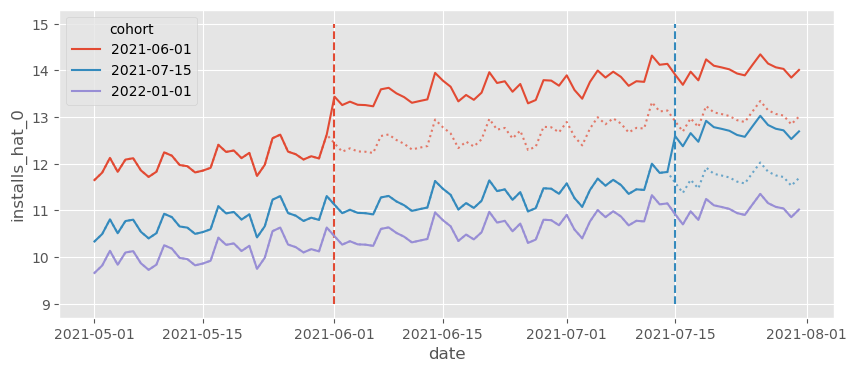

In [48]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat":0}))})
          

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

该图展示了 TWFE 如何将它在控制单位中看到的趋势投影到被处理单位，并调整基准水平。例如，如果我们看红色队列的线，反事实 $Y_0$ 是来自蓝色和紫色队列的平均趋势（趋势投影），但水平上移到红色队列的水平（水平调整）。这就是我们把 TWFE 看成双重差分方法的原因。它既做了趋势投影和水平调整，又适用于多个时间段和多个单位（在两个单位和两个时间段的情况中，TWFE 与 DiD 等价）。

## 2) 死亡：效应异质性下的失败

正如我们刚才看到的，DiD 和 TWFE 有其优点。它可以很好地估计反事实，既适应时间又适应单位差异，这使其成为一种强大的因果推断技术。但如果事情仅止于此，我们就无需这一章了，因为这在本书的第一部分已有涵盖。最近发生的事情是，许多学者注意到将 2×2 的 DiD 扩展到多期的 TWFE 并不像我们最初想象的那样简单。事实上，在许多现实应用中，**TWFE 在其通常的形式下被证明是有偏的**。这一发现导致经济学中依赖这种技术的多项研究被重新审视。要理解这一切，最好的起点是阐明模型背后的假设。

![img](./images/24/death.png)

为简便起见，让我们考虑不含时间效应的固定效应模型：

$$
y_{it} = \tau D_{it} + \gamma_i + e_{it}
$$

我们可以将该模型的假设分成两组：

1. **函数形式假设：**
    * 时间上无异质效应（效应恒定）；
    * 协变量与结果的线性关系；
    * 加性固定效应。
2. **严格外生性：**
    * 平行趋势；
    * 无预期（处理前无影响）；
    * 无未观测的随时间变化的混杂因素；
    * 过去的处理不影响当前结果（无延滞效应）；
    * 过去的结果不影响当前处理（无反馈）。

在这里，我们将坚持讨论函数形式假设。协变量的线性假设众所周知，适用于所有线性回归模型。但正如我们在“去偏/正交机器学习”一章中看到的，我们可以用机器学习模型轻松放松这一假设。这意味着如果愿意，我们可以放松这一假设。至于加性固定效应，这并不是一个过于限制性的假设，因此问题不大。我想重点关注的（并引起广泛讨论）的，是时间上无异质效应这个假设。

### 时间上的处理效应异质性

如果你曾在营销或科技行业工作过，你就知道事情需要时间才能成熟。如果你推出一个新功能，用户需要时间去适应。同样，开展营销活动时，该活动的影响不会立刻显现。它会随着时间成熟，甚至在活动结束后仍能吸引新用户。这**不是**我们之前安装数据中看到的模式。那里面，安装量在队列被处理的时刻立刻跃升。如果我们将其改成更符合现实的情况会怎样？具体来说，我们仍然让 ATT 为 1，但现在它需要 10 天才能成熟（因此在处理的第一天效应为 0.1，第二天为 0.2，以此类推，直到第 10 天达到 1）。另外，我会减少时间和单位效应的大小，这样总体趋势更容易看清。


In [54]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"])

units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date, len(units)), 
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days / 70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2 * d["unit_fe"] + 0.05 * d["time_fe"] + d["w_seas"] / 50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1 * (np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

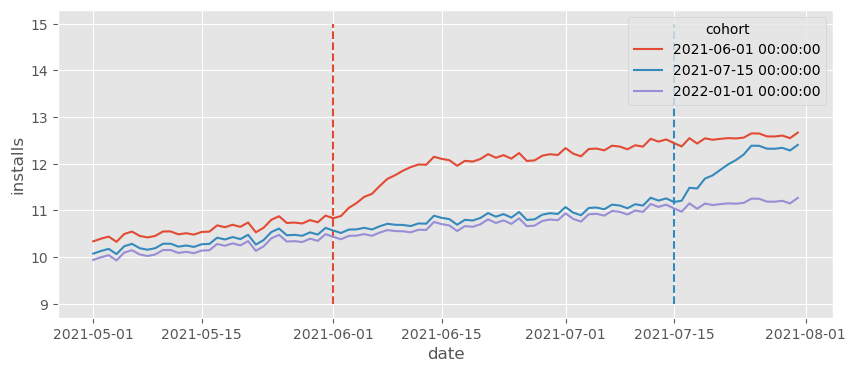

In [58]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

我们看到安装量最终仍然达到之前的水平，但需要一段时间（10 天）。这似乎合理吧？现实生活中的大多数数据都是这样，效应需要一些时间才能成熟。好的，让我们在这些数据上运行 TWFE 模型，看看会发生什么。

In [69]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect: ", twfe_model.params["treat"])
print("True Effect: ", df_heter.query("treat==1")["tau"].mean())

Estimated Effect:  0.786770822572485
True Effect:  0.8544117647058823


首先要注意，真实的 ATT 不再是 1，因为在最初的几个时期它会较小。其次，更重要的是，我们看到**TWFE 的估计 ATT 不再恢复真实的 ATT**。简单地说：TWFE 有偏。但为什么呢？在这里我们有平行趋势、无预期以及所有其他严格外生性假设。那到底发生了什么？

理解这一问题的第一步是意识到 TWFE 实际上可以分解为多个 2×2 的 DiD。在我们的例子中，这将包括：比较早期处理与从未处理、比较后期处理与从未处理、比较早期处理与后期处理（以后期处理作为对照）以及比较后期处理与早期处理（以早期处理作为对照）这四种比较：


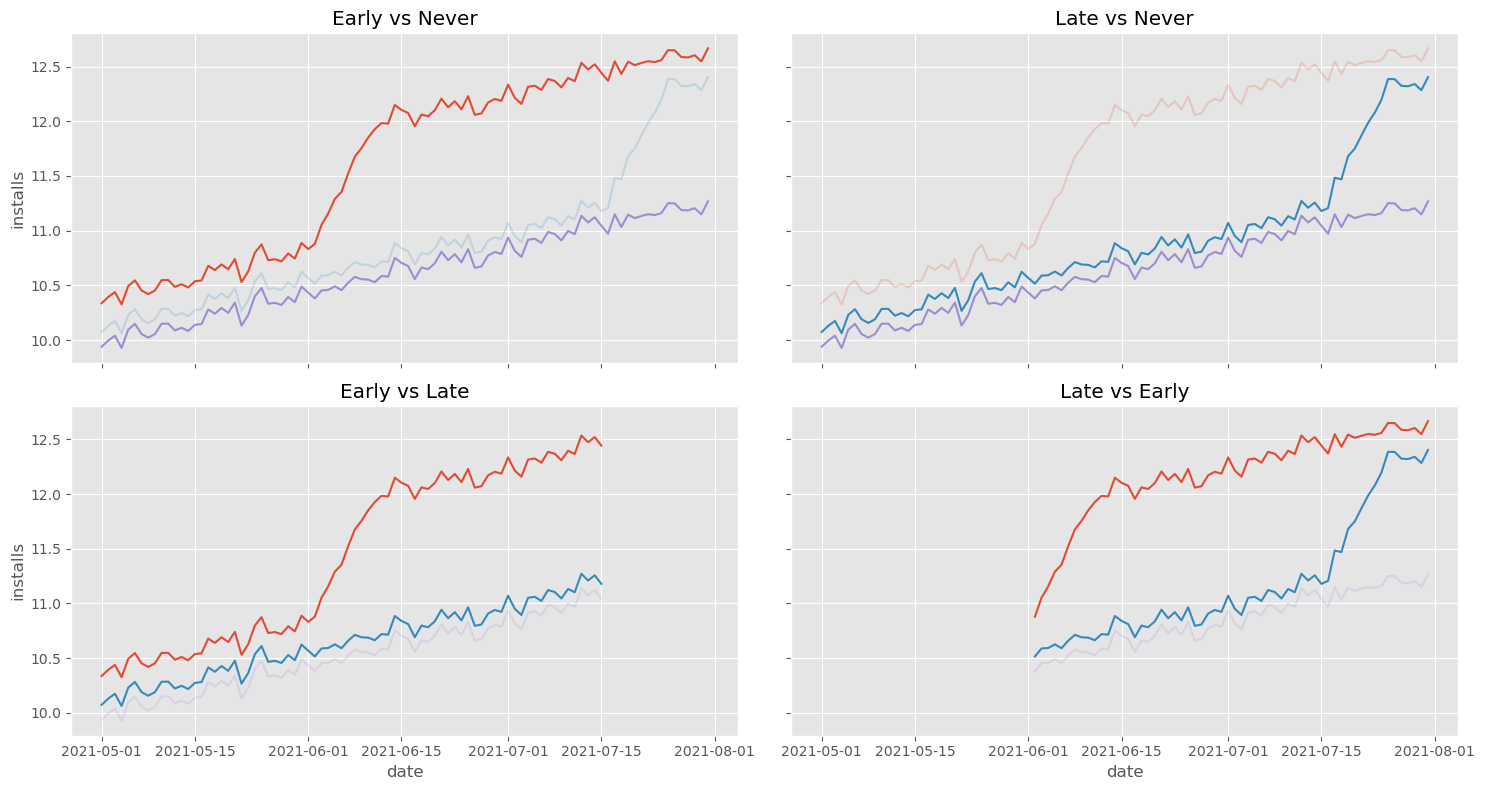

In [104]:
# 译者注： 原始代码因调色板未涵盖全部 cohort 值而报错。此处已修正为自动匹配调色板，并单独绘制排除组以实现正确对比效果。
g_plot_data = (
    df_heter
    .groupby(["cohort", "date"])["installs"]
    .mean()
    .reset_index()
    .astype({"cohort": str})
)


unique_cohorts = sorted(g_plot_data["cohort"].unique())
palette = dict(zip(unique_cohorts, sns.color_palette(n_colors=len(unique_cohorts))))


fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True)


def plot_comp(df, ax, exclude_cohort, name):
    exclude_cohort_str = str(pd.to_datetime(exclude_cohort).date())


    df_main = df[df["cohort"] != exclude_cohort_str]
    df_excl = df[df["cohort"] == exclude_cohort_str]


    sns.lineplot(
        data=df_main,
        x="date",
        y="installs",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )


    color = palette.get(exclude_cohort_str, "gray")
    sns.lineplot(
        data=df_excl,
        x="date",
        y="installs",
        color=color,
        alpha=0.2,
        legend=None,
        ax=ax
    )

    ax.set_title(name)


plot_comp(g_plot_data, axs[0, 0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0, 1], cohorts[0], "Late vs Never")
plot_comp(g_plot_data[g_plot_data["date"] <= pd.to_datetime(cohorts[1])], axs[1, 0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"] > pd.to_datetime(cohorts[0])], axs[1, 1], cohorts[-1], "Late vs Early")


plt.tight_layout()

前三个比较没有什么可担心的，主要是因为它们使用的控制组行为良好。然而，第四个比较，即“晚期 vs 早期”是有问题的。注意这个比较使用早期处理组作为控制。同时注意早期处理组有奇怪的行为：它在开始时急剧上升。这反映了我们的 ATT 并非即时，而是需要 10 天才能成熟。从直觉上看，我们可以看到这会扰乱 DiD 中反事实趋势的估计，使其比实际的更陡峭。为了直观展示这一点，让我们绘制上述第四组中晚期处理的反事实 $Y_0$。


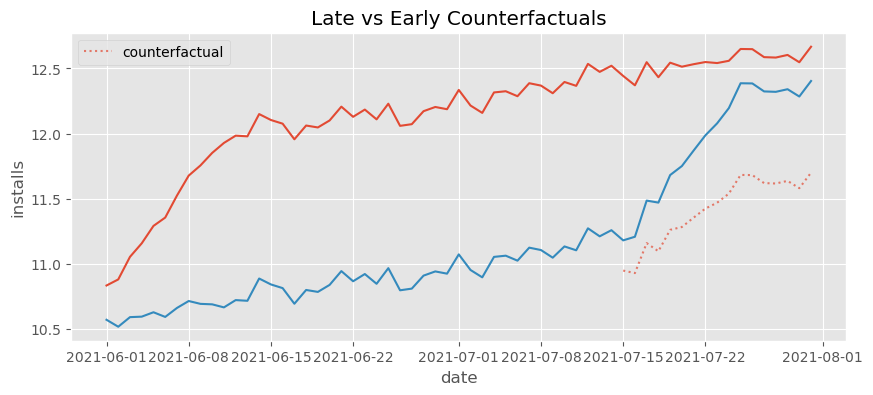

In [107]:
late_vs_early = (df_heter
                 [df_heter["date"].astype(str)>="2021-06-01"]
                 [lambda d: d["cohort"].astype(str)<="2021-08-01"])


formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=late_vs_early).fit()

late_vs_early_pred = (late_vs_early
                      .assign(**{"installs_hat_0": twfe_model.predict(late_vs_early.assign(**{"treat":0}))})
                      .groupby(["cohort", "date"])
                      [["installs", "installs_hat_0"]]
                      .mean()
                      .reset_index())


plt.figure(figsize=(10,4))
plt.title("Late vs Early Counterfactuals")
sns.lineplot(
    data=late_vs_early_pred,
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

sns.lineplot(
    data=(late_vs_early_pred
          [late_vs_early_pred["cohort"].astype(str) == "2021-07-15"]
          [lambda d: d["date"].astype(str) >= "2021-07-15"]
         ),
    x="date",
    y ="installs_hat_0",
    alpha=0.7,
    color="C0",
    ls="dotted",
    label="counterfactual"
);

正如我们所说的，反事实的趋势比它应该有的要陡得多。它捕捉了早期处理开始时的快速增长，并将这种趋势投射到了后期处理组上。

从更技术的角度看，可以证明（Goodman-Bacon, 2019）即便在严格外生（平行趋势、无预期…）的情况下，如果各个队列规模相同，TWFE 估计量收敛于

$$
plim_{x \to \infty} \hat{\tau}^{TWFE} = VWATT - \Delta ATT
$$

第一个项是来自多个 DiD 比较（如我们先前看到的）的方差加权 ATT，这正是我们想要的。然而，这里还有一个额外的 $\Delta ATT$ 项，它表示 ATT 随时间变化的幅度，这正是导致估计偏差的原因。观察这个项，我们可以看到：如果效应随时间增大（如我们的例子），估计将向下偏；如果效应随时间减小，则向上偏。

在上述例子中，我们看到 TWFE 的估计效应小于真实的 ATT。但情况可能更极端。我认为值得再看一个例子，以说明这种偏差会强大到甚至颠倒真实 ATT 的符号。让我们考虑一个非常简单的过程，只有两个队列。在这个例子中，处理效应是负的，并且每天减少 0.1。我还去掉了所有时间固定效应和趋势，这样我们可以真正看清发生了什么。


In [110]:
date = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-06-15"])
units = range(1, 100+1)

np.random.seed(1)

df_min = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
)).assign(
    trend = 0,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 - d["trend"] + 0.1*d["unit_fe"]
).assign(
    y1 = lambda d: d["y0"] - 0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days))
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


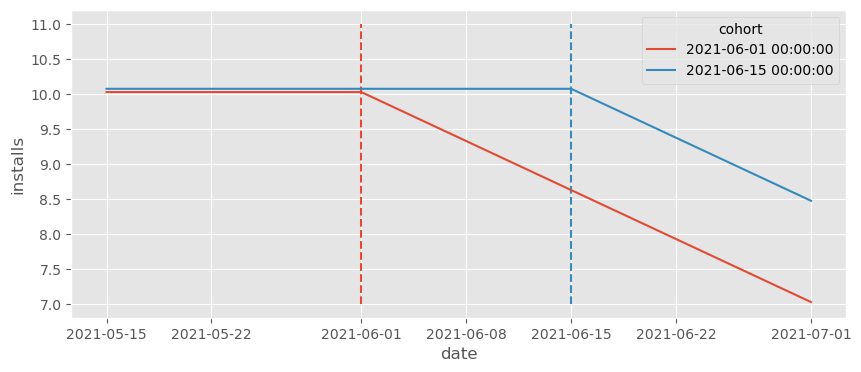

In [112]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_min
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

从上面的图可以明显看出，ATT 是负的，对吗？正确的反事实应该是一条大约在 11 附近的直线。然而，如果我们运行 TWFE 估计器，我们得到的却是正的效应！


In [115]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_min).fit()

twfe_model.params["treat"]

0.05000000000001685

再次说明，要弄清发生什么，请把注意力放在用早期处理队列作为控制的比较上。记住，与 DiD 类似，TWFE 会将控制组的趋势调整到处理组的水平，因此反事实应该反映这一点。


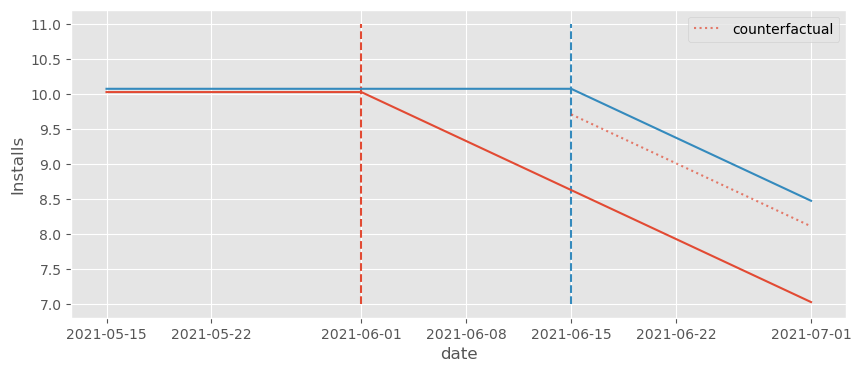

In [118]:
df_pred = df_min.assign(**{"installs_hat_0": twfe_model.predict(df_min.assign(**{"treat":0}))})
          
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

注意反事实的水平被压低了。由于早期处理组的效应在下降，这将反事实水平从 10 推低到约 9.5。不仅如此，反事实还调整出一个本不该存在的下降趋势。从图中可以明显看出，正确的反事实应该是一条水平线在 10，但却成了一条向下倾斜的线……


In [121]:
df_min_rel = (df_min
              .assign(relative_days = (df_min["date"] - df_min["cohort"]).dt.days))

df_min_rel.head()

,date,unit,cohort,unit_fe,trend,day,treat,y0,y1,tau,installs,relative_days
0,2021-05-15,1,2021-06-15,-3.435864,0,0,0,9.656414,9.656414,0.0,9.656414,-31
1,2021-05-16,1,2021-06-15,-3.435864,0,1,0,9.656414,9.656414,0.0,9.656414,-30
2,2021-05-17,1,2021-06-15,-3.435864,0,2,0,9.656414,9.656414,0.0,9.656414,-29
3,2021-05-18,1,2021-06-15,-3.435864,0,3,0,9.656414,9.656414,0.0,9.656414,-28
4,2021-05-19,1,2021-06-15,-3.435864,0,4,0,9.656414,9.656414,0.0,9.656414,-27


Then, we can pass that column as a category so our model will estimate the expected number of installs for each period relative to the treatment. We can then define the effect as the extra expected number of installs compared to relative day -1, which is the last day prior to the treatment.
 
We might think that this formulation would capture the time heterogeneity in the ATT and solve all our issues. Unfortunately, that is not the case. If we try it out and plot the counterfactuals, we can see that they are far from where they should intuitively be (the horizontal line at 11).

In [124]:
# remove the intercept, otherwise effects will be relative to relative day -30
formula = f"installs ~ -1 + C(relative_days) + C(date) + C(unit)"

twfe_model = smf.ols(formula, data=df_min_rel).fit()

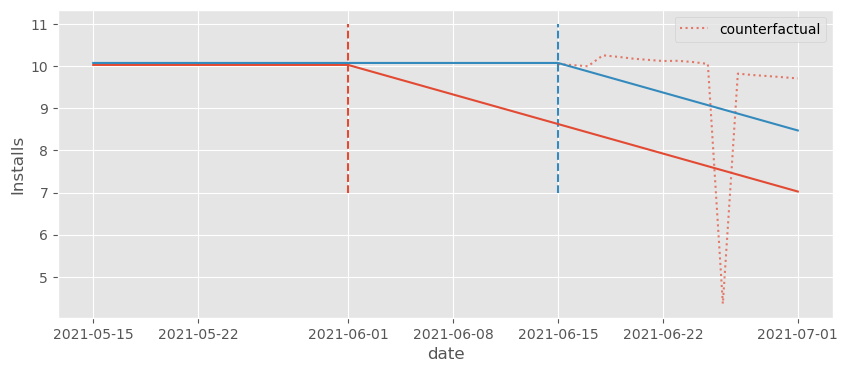

In [125]:
df_pred = df_min_rel.assign(
    installs_hat_0=twfe_model.predict(df_min_rel.assign(relative_days=-1))
) 

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

![img](./images/24/awful.jpeg)

不过这些反事实略好一些。我们可以看到它们位于实际的 $Y_1$ 之上。因此，我们至少会估计出一个负效应，这是应该的。为了看到这一点，我们可以通过先提取与每个虚拟变量相关联的参数，再从这些参数中减去相对第 -1 天（基线）对应的参数，来绘制估计的效应。


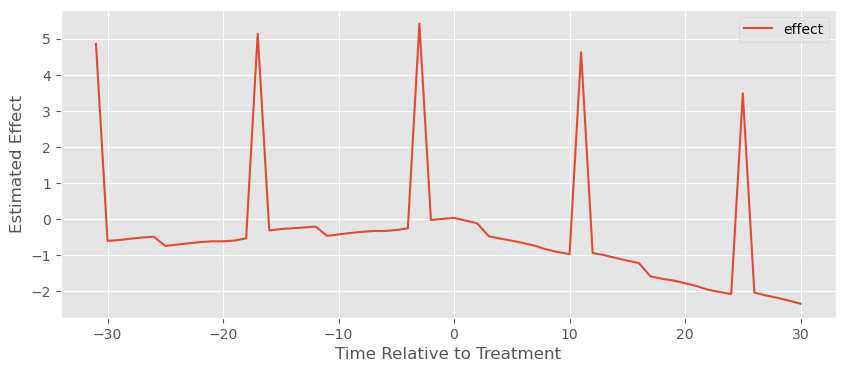

In [129]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("relative_days")]
           .reset_index()
           .rename(columns={0:"effect"})
           .assign(relative_day=lambda d: d["index"].str.extract(r'\[(.*)\]').astype(int))
           # set the baseline to period -1
           .assign(effect = lambda d: d["effect"] - d.query("relative_day==-1")["effect"].iloc[0]))

# effects
effects.plot(x="relative_day", y="effect", figsize=(10,4))
plt.ylabel("Estimated Effect")
plt.xlabel("Time Relative to Treatment");

我们可以看到它稍微好了一些，因为至少在处理之后估计的效应 1）大多为负，2）总体呈下降趋势。但仍然出现了一些奇怪的尖峰，以及类似于正的处理前效应的东西，这显然不合理。

问题依旧是我们一直讨论的：由于处理的时间不同，早期处理组被用作晚期处理组的控制，这导致模型估计出非常奇怪的反事实趋势。结论是，仅仅在模型中加入相对于处理时间的虚拟变量并不能解决问题。那么，到底应该怎么做呢？

## 3) 启蒙：更灵活的函数形式

有好消息也有坏消息。先说好消息：我们已经把问题归结为函数形式方面，因此可以通过修正函数形式来解决。具体而言，我们反复提到 TWFE 的这种特定偏差源自时间异质的效应。这种情况会发生，原因之一是处理效应需要时间才能成熟（例如，一场营销活动可能需要 10 天才能达到完全效果）。换句话说，传统 TWFE 的函数形式不够灵活，无法捕捉这种异质性，导致了我们讨论的偏差。大多数情况下，认识到问题本身就已在寻找解决方案的路上走了很远。

在上一节末尾，我们看到仅仅允许与处理相对时间的每个时期有不同的效应（事件研究设计）是不够的。尽管那样做提高了模型的灵活性，但并没有真正解决问题。我们需要想办法让模型比这更灵活。


In [132]:
formula = f"""installs ~ treat:C(cohort):C(date) + C(unit) + C(date)"""

# for nicer plots latter on
df_heter_str = df_heter.astype({"cohort": str, "date":str})

twfe_model = smf.ols(formula, data=df_heter_str).fit()

为此，让我们回到最初的例子，即我们试图建模推出一个新功能（处理）带来的新增安装数量。我们看到简单的 TWFE 模型在这里不起作用：

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

不仅如此，我们知道它不起作用是因为它太过限制性。它强迫效应对于所有时间和单位都是相同的，即 \(\tau_{it} = \tau \ \forall i, t\)，也就是说它强迫时间同质。如果这是问题所在，一个简单的解决办法是允许每个时间和每个单位有不同的效应：

$$
Installs_{it} = \sum_{i=0}^N \sum_{t=0}^T \tau_{it} D_{it} + \gamma_i + \theta_t + e_{it}
$$

这等价于运行下面的公式：

```
installs ~ treat:C(unit):C(date) + C(unit) + C(date)
```

不幸的是，我们不能拟合这个模型。这会使参数数量超过数据点数量。因为我们对日期和单位进行了交互，我们将拥有每个单位每个时间段的一个处理效应参数，共 \(T*N\) 个参数，但这恰好是我们的样本数量！OLS 无法运行。

好吧，现在我们需要减少模型的处理效应参数数量。为此，我们可以考虑某种方式对单位进行分组。如果稍微思考一下，我们可以看到一种很自然的分组方式：按 cohort（队列）分！我们知道整个队列的效应随时间遵循同一模式。因此，对上面那个不切实际模型的一个自然改进是允许效应随 cohort 而不是单位变化：

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=0}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

其中 `G` 是 cohort 的总数，`g` 标记每个具体 cohort。该模型的处理效应参数数量更为合理（\(T*G\)），因为 \(G\) 通常远小于 \(N\)。现在，我们终于可以运行它。


In [135]:
df_pred = (df_heter_str
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str.assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))

print("Number of param.:", len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred. Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

Number of param.: 467
True Effect:  0.8544117647058823
Pred. Effect:  0.8544117647058584


为了检验这个模型是否有效，我们可以像之前那样把 `treat` 设为零以获取 $Y_0$ 的反事实预测。然后，我们将观察到的处理结果 $Y_1$ 减去 $\hat{Y}_0$ 来估计效应。让我们看看这是否与真实的 ATT 相匹配。


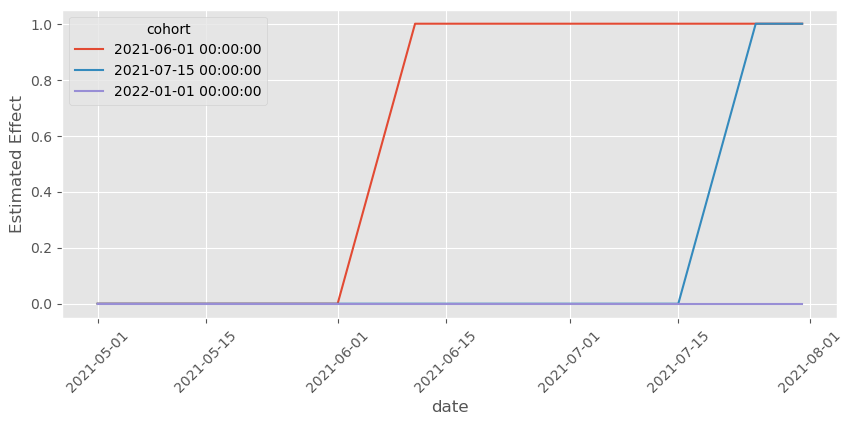

In [138]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect");

确实如此！我们终于建立了一个足够灵活的模型来捕捉时间异质性，从而能够估计正确的处理效应！我们还可以做另一件有趣的事情：按时间和 cohort 提取估计的效应并绘制它们。在这种情况下，由于我们知道数据是如何生成的，我们知道应该期待什么。也就是说，对每个 cohort 而言，在处理前效应应为零，处理后第 10 天效应应为 1，并且在处理后到第 10 天之间应是一条从 0 升到 1 的直线。

再一次，这张图与我们对效应的预期相匹配。它们遵循我们前面描述的确切模式。

这已经非常好，但我们还能做得更好。首先注意，这个模型有大量参数。由于我们有 100 个单位和约 92 天的数据，我们知道其中 192 个参数是单位和时间固定效应。即便如此，仍然剩下 250 多个处理效应参数。

如果我们假定在处理前效应为零（没有预期效应），我们可以通过从交互项中删去处理前的日期来减少参数数量。

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

此外，我们可以从交互项中删去控制 cohort，因为其在处理前的效应始终为零

$$
Installs_{it} = \sum_{G=q}^g \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

其中 $g<q$ 的 cohort 被视为控制 cohort。

不过，要用公式实现这一点很棘手，所以我们需要先做一些特征工程。也就是说，我们将手动创建 cohort 虚拟变量，生成一列在 cohort 为 `2021-06-01` 时取 1 否则取 0，另一列在 cohort 为 `2021-07-15` 时取 1 否则取 0。此外，我们还会创建一个日期列，用于 `2021-06-01` cohort，将该 cohort 日期之前的所有日期折叠到一个 `control` 类别。对于 `2021-07-15` cohort 的日期，我们可以做类似的处理。下面是代码示例。


In [141]:
def feature_eng(df):
    return (
        df
        .assign(date_0601 = np.where(df["date"]>="2021-06-01", df["date"], "control"),
                date_0715 = np.where(df["date"]>="2021-07-15", df["date"], "control"),)
        .assign(cohort_0601 = (df["cohort"]=="2021-06-01").astype(float),
                cohort_0715 = (df["cohort"]=="2021-07-15").astype(float))
    )

formula = f"""installs ~ treat:cohort_0601:C(date_0601) 
                       + treat:cohort_0715:C(date_0715) 
                       + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df_heter_str.pipe(feature_eng)).fit()

如果我们现在像之前那样进行反事实预测，可以看到估计的效应仍然完全吻合真实效应。这里的好处是我们有一个简单得多的模型，只有大约 80 个处理效应参数（记住，其中 192 个参数是时间和单位固定效应）。


In [144]:
df_pred = (df_heter
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str
                                                           .pipe(feature_eng)
                                                           .assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))


print(len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

271
True Effect:  0.8544117647058823
Pred Effect:  0.854411764705862


绘制这些处理效应参数，可以看到我们已经移除了控制 cohort 的那些以及 cohort 被处理前日期的那些。


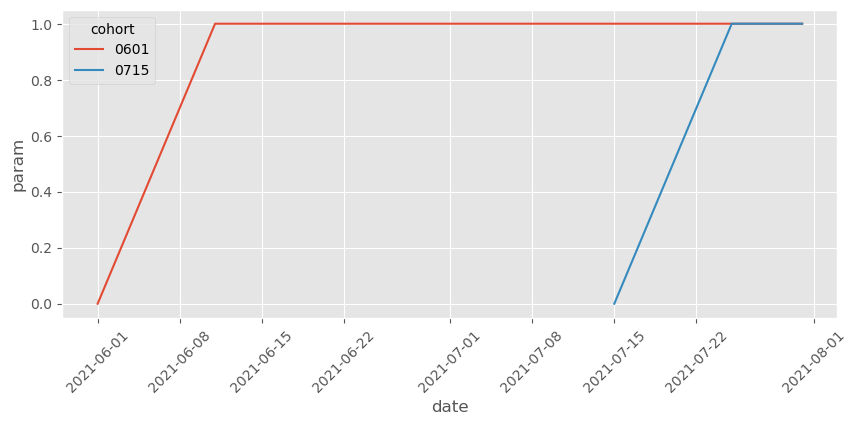

In [147]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r':cohort_(.*):'),
                   date_0601=lambda d: d["index"].str.extract(r':C\(date_0601\)\[(.*)\]'),
                   date_0715=lambda d: d["index"].str.extract(r':C\(date_0715\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date_0601"].combine_first(d["date_0715"]), errors="coerce")))

           
plt.figure(figsize=(10,4))
sns.lineplot(data=effects.dropna(subset=["date"]), x="date", y="param", hue="cohort")
plt.xticks(rotation=45);

注意我们还可以进一步简化，因为两个 cohort 的效应遵循相同的形状。具体而言，我们可以限制模型让两个 cohort 的效应相同，只随时间变化。为此，我们需要创建一列表示距离处理后的天数，就像事件研究设计那样：

```
days_after_treat=1(date>cohort)*(date - cohort)
```

然后将其与处理指示变量交互：

```
installs ~ treat:C(days_after_treat) + C(unit) + C(date)
```

不过，我认为我们可以到此为止。通常不允许 cohort 之间的异质性是一个坏主意，因为处理效应倾向于随着日历时间变化，而不仅仅是随着距离处理的时间变化。例如，可能一段时间后，竞争对手复制了我们的功能，使其不再像以前那样具有吸引力。在这种情况下，新功能对安装量的效应会随着时间减弱。

除了展示随时间变化的效应，我们还应该做的一件事是绘制反事实，以判断它们是否在合理的位置。我知道这不是对模型特别科学的验证，但相信我，它很有帮助。下面是结果。


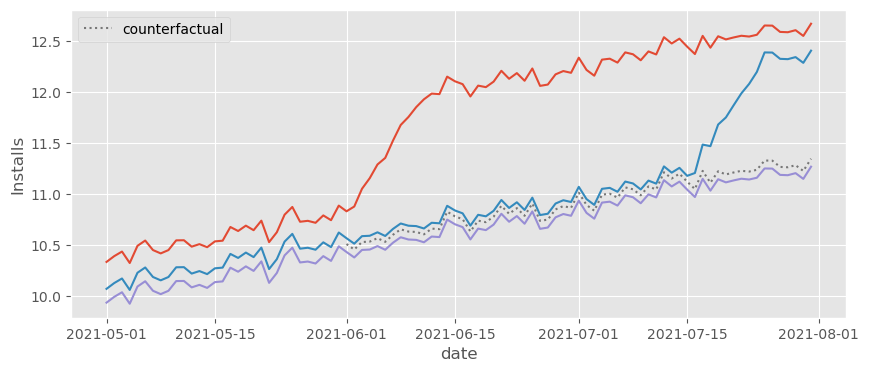

In [150]:
twfe_model_wrong = smf.ols("installs ~ treat + C(date) + C(unit)",
                           data=df_pred).fit()


df_pred = (df_pred
           .assign(**{"installs_hat_0_wrong": twfe_model_wrong.predict(df_pred.assign(**{"treat":0}))}))


plt.figure(figsize=(10,4))
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-01")]
          .groupby(["date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    ls="dotted",
    color="C3",
    label="counterfactual",
)

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

plt.ylabel("Installs");

正如我们所看到的，反事实 $Y_0$ 的预测正好落在我们认为应该落的地方，即非常接近控制 cohort。这令人欣慰。我们知道 TWFE 模型通过比较处理 cohort 的结果与该反事实来估计处理效应，即 $Y - \hat{Y_0}$。既然反事实看起来没问题，我们可以放心处理效应也大概率没问题。

这是好消息，但别以为我忘了之前答应你的坏消息。尽管我们解决了 TWFE 的函数形式问题，但 DiD 和 TWFE 还有一个更大的问题，那就是其独立性假设。

在使用 DiD 和 TWFE 时，我们经常引入平行趋势假设，却不真正思考该假设究竟意味着什么。遗憾的是，平行趋势假设比大多数人意识到的要严格得多、可信度也低得多。但由于这一章已经非常长，我觉得可以在此打住，让我们享受一下 DiD 的小胜利。

## 关键观点

我想可以肯定地说，我们不仅理解了 TWFE 的函数形式问题，还成功地修正了它。我们追溯问题的根源（时间异质性），并通过提供更多的灵活性加以修复。现在我们可以去喝一杯放松一下，因为 TWFE 再次看起来可以安全使用。或者……真的可以吗？

![img](./images/24/twfeworking.png)

我们千万不要忘记，TWFE（更广义上的 DiD）混合了**函数形式假设和独立性假设**。在本章中，我们仅解决了函数形式的问题，但屋子里仍有一个大象：平行趋势假设。平行趋势是 DiD 所做的独立性假设。这很有名。但我觉得我们并不真正理解这一假设的含义。我们只是凭空假设它成立，好像这样就能让它成为现实。不幸的是，平行趋势假设要求的条件远比大多数人意识到的多。在接下来的章节中，我们将看到为什么会这样，以及我们是否能对此有所作为。

## 参考说明

这一章写了很久。最近的计量经济学文献涌现了许多关于 DiD 问题及其解决方法的新思想和见解。我们可以从多个角度来看这些问题，从而可以利用多种方法来解决它们。请做好准备，因为这里的参考文献列表将会很长（而且可能组织得并不那么好）。

首先，我大量参考了 Andrew Goodman‑Bacon 的《Difference‑in‑Differences with Variation in Treatment Timing》。他对问题的诊断非常巧妙直观，而且文中有一些很棒的图帮助我清楚理解 DiD 发生了什么。本章中的一些图片几乎直接复制自 Goodman‑Bacon 的作品。

第二个主要灵感来源是 Pedro H.C. Sant'Anna 和 Brantly Callaway 的《Difference‑in‑Differences with Multiple Time Periods》。注意 Callaway 和 Sant'Anna 对这一问题的解决思路与我们采取的路线不同。不过，他们的解决方案为理解 DiD 问题提供了很多启示，使之容易理解。除此之外，Pedro 有一篇很好的博客文章展示 TWFE 的问题。那篇博客中的数据生成过程深深启发了我在这里使用的示例。我基本上是把 Pedro 的代码从 R 翻译成 Python。Pedro 还非常友好地帮我解答了关于 DiD 假设的一些问题。他还有另一篇很有趣的文章讨论了在 DiD 模型中加入协变量的问题，这里没有涉及，因为章节已经很长了。这篇文章名为《Doubly Robust Difference‑in‑Differences Estimators》，如果你打算在模型中加入协变量，我强烈建议你阅读。

最后，但绝不是最不重要的，我们在这里使用的函数形式修正灵感来自 Sun 与 Abraham 的《Estimating dynamic treatment effects in event studies with heterogeneous treatment effects》以及 Jeffrey Wooldridge 的《Two‑Way Fixed Effects, the Two‑Way Mundlak Regression, and Difference‑in‑Differences Estimators》。虽然我很喜欢 Callaway 和 Sant'Anna 在他们的论文中所做的工作，但他们的解决方案实现起来略为复杂。相比之下，Sun、Abraham 和 Wooldridge 的解决方案只需要在 TWFE 回归模型中巧妙地处理交互项，用 `statsmodels` 和一些公式就能轻松实现。

除了上述论文，我还参考了 Taylor Wright 在 YouTube 上组织的 DiD Study Group 中的演示。在听作者亲自讲解这些文章之后再去阅读文章，会容易理解得多。我还非常感谢徐亦青教授，他在 YouTube 上的“Panel Data 的因果推断”课程中将这一切串联起来。

最后，请记住我也在学习。因此，如果你发现任何荒谬的地方，请提出 issue，我会尽力处理。

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。